In [24]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from facenet_pytorch.models.mtcnn import PNet, RNet, ONet  # Import P-Net, R-Net, O-Net
from facenet_pytorch import MTCNN
import os
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from torch.nn.functional import normalize



In [25]:
match_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Game'  # match photos
studio_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Players\Studio_photos'  # studio photos

In [26]:
# Define fine-tuned P-Net, R-Net, and O-Net for finetuning
class FinetunedMTCNN(MTCNN):
#(self, image_size=160, margin=5, **kwargs): # use this after some time to improve the final results
    def __init__(self, **kwargs):
        super(FinetunedMTCNN, self).__init__(**kwargs)
        # Create your custom, finetuned P-Net, R-Net, O-Net here
        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()
    def forward(self, x):
        # Overriding forward pass if additional finetuning is needed
        return super().forward(x)

In [27]:
# Initialize FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval()  # Load the FaceNet model
# Initialize mtcnn model
finetuned_mtcnn = FinetunedMTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu', min_face_size=60)

In [28]:
def find_euclidean_distance(src, dst):
    return np.linalg.norm(src - dst)

In [29]:
def alignment_procedure(img, left_eye, right_eye):    
    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye
    
    # Find the direction to rotate the image based on the eye coordinates
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1  # Clockwise
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1  # Counter-clockwise
    
    # Calculate the length of the triangle edges
    a = find_euclidean_distance(np.array(left_eye), np.array(point_3rd))
    b = find_euclidean_distance(np.array(right_eye), np.array(point_3rd))
    c = find_euclidean_distance(np.array(left_eye), np.array(right_eye))
    
    # Apply cosine rule to find the angle
    if b != 0 and c != 0:  # Avoid division by zero
        cos_a = (b**2 + c**2 - a**2) / (2 * b * c)
        angle = np.arccos(cos_a)  # Angle in radians
        angle = np.degrees(angle)  # Convert to degrees
        
        # Adjust the angle based on the rotation direction
        if direction == -1:
            angle = 90 - angle
        
        # Rotate the image using PIL
        #img = Image.fromarray(img)
        img = img.rotate(direction * angle, resample=Image.BICUBIC)
        img = np.array(img)  # Convert back to numpy array
        # aligned_img_pil = Image.fromarray(img)  # Convert back to PIL Image for saving
        # aligned_img_pil.show()
    return img

In [30]:
# Function to perform face detection and store image paths with their cropped face regions
def process_and_save_match_faces(image_folder, mtcnn_model, margin=0):
    global match_photos_all
    match_photos_all = []
    match_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.95
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                #print(f"Number of filtered faces: {len(filtered_faces)}")
                # Process each filtered face
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    box = [int(b) for b in box]  # Ensure the box is in integer format
                    # adding margin around the box
                    # Apply margin to the bounding box
                    x1 = max(0, box[0] - margin)  # Left
                    y1 = max(0, box[1] - margin)  # Top
                    x2 = min(image.width, box[2] + margin)  # Right
                    y2 = min(image.height, box[3] + margin)  # Bottom
                    # Crop the face from the image
                    cropped_face = image.crop((x1, y1, x2, y2))
                    if cropped_face is not None:
                        # Get the landmarks (left and right eyes) for the current face
                        left_eye = landmarks[i][0]  # Left eye coordinates for face i
                        right_eye = landmarks[i][1]  # Right eye coordinates for face i
                        # Align the cropped face using the eye coordinates
                        aligned_face = alignment_procedure(cropped_face, left_eye, right_eye)
                        # Store the aligned face and the original image path
                        match_photos_all.append(aligned_face)
                        match_photos_paths.append(image_path)  # Store original image path
    return match_photos_paths  # Return list of original image paths

In [31]:
def process_and_save_studio_faces(image_folder, mtcnn_model, margin=0):
    global studio_photos_all
    studio_photos_all = []
    studio_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.95
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save original image paths and face regions that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    box = [int(b) for b in box]  # Ensure the box is in integer format
                    # Apply margin to the bounding box
                    x1 = max(0, box[0] - margin)  # Left
                    y1 = max(0, box[1] - margin)  # Top
                    x2 = min(image.width, box[2] + margin)  # Right
                    y2 = min(image.height, box[3] + margin)  # Bottom
                    # Crop the face from the image
                    cropped_face = image.crop((x1, y1, x2, y2))
                    if cropped_face is not None:
                        left_eye = landmarks[i][0]
                        #print(left_eye)
                        right_eye = landmarks[i][1]
                        #print(right_eye)
                        aligned_face = alignment_procedure(cropped_face, left_eye, right_eye)
                        studio_photos_all.append(aligned_face)
                        studio_photos_paths.append(image_path)  # Store original image path
    return studio_photos_paths  # Return list of original image paths


In [32]:
def get_face_embedding(image):
    image = cv2.resize(image, (160, 160))
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    embedding = facenet(image)
    embedding = normalize(embedding, p=2, dim=1)  # L2 normalization of embeddings
    return embedding.detach().numpy()

In [33]:
# Function to calculate Cosine Similarity between embeddings
def cosine_similarity_metric(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

In [34]:
# Process both match and studio images, and return original image paths
studio_photos_paths = process_and_save_studio_faces(studio_images_folder, finetuned_mtcnn, margin=200)
studio_image_shapes = [np.array(image).shape for image in studio_photos_all]
print("Shapes of images in the list studio_photos_all:", studio_image_shapes)
print(f"Number of studio photos: {len(studio_photos_all)}")

Shapes of images in the list studio_photos_all: [(1381, 1178, 3), (1364, 1160, 3), (1476, 1224, 3), (1223, 1043, 3), (1302, 1080, 3), (1208, 1081, 3), (1329, 1116, 3), (1460, 1241, 3), (1336, 1156, 3), (1268, 1113, 3), (1301, 1124, 3), (1330, 1211, 3)]
Number of studio photos: 12


In [35]:
# Generate embeddings for studio photos
studio_embeddings = []
for i, studio_photo in enumerate(studio_photos_all):
    studio_image = np.array(studio_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(studio_image)  # Get embedding
    if embedding is not None:
        studio_embeddings.append((i, embedding))  # Store the index and embedding

In [36]:
# Process and return original match photo paths
match_photos_paths = process_and_save_match_faces(match_images_folder, finetuned_mtcnn, margin=40)
match_image_shapes = [np.array(image).shape for image in match_photos_all]
print("Shapes of images in the list match_photos_all:", match_image_shapes)
print(f"Number of match photos: {len(match_photos_all)}")

Shapes of images in the list match_photos_all: [(229, 211, 3), (190, 187, 3), (130, 121, 3), (116, 110, 3), (259, 229, 3), (263, 226, 3), (262, 223, 3), (256, 226, 3), (450, 369, 3), (410, 330, 3), (210, 160, 3), (376, 315, 3), (365, 346, 3), (385, 357, 3), (301, 264, 3), (302, 267, 3), (683, 546, 3), (227, 209, 3), (194, 185, 3), (131, 121, 3), (119, 112, 3), (370, 305, 3), (297, 264, 3), (259, 229, 3), (227, 217, 3), (346, 293, 3), (246, 222, 3), (237, 192, 3), (240, 215, 3), (229, 173, 3), (643, 501, 3), (213, 196, 3), (364, 295, 3), (229, 211, 3), (187, 174, 3), (136, 125, 3), (117, 112, 3), (371, 309, 3), (364, 302, 3), (348, 301, 3), (382, 324, 3), (277, 246, 3), (265, 229, 3), (371, 334, 3), (359, 336, 3), (362, 310, 3), (275, 221, 3), (348, 302, 3), (464, 406, 3), (331, 297, 3), (349, 310, 3), (310, 286, 3), (241, 225, 3), (238, 204, 3), (297, 238, 3), (570, 467, 3), (548, 427, 3), (257, 219, 3), (261, 222, 3), (248, 224, 3), (373, 322, 3), (296, 245, 3), (264, 223, 3), (385, 3

In [37]:
# Generate embeddings for match (game) photos
game_embeddings = []
for i, match_photo in enumerate(match_photos_all):
    match_image = np.array(match_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(match_image)  # Get embedding
    if embedding is not None:
        game_embeddings.append((i, embedding))  # Store the index and embedding


In [56]:
# Compare studio embeddings with match embeddings
results = {}
threshold = 0.4  # Define a similarity threshold for matches

In [57]:
for studio_idx, studio_embedding in studio_embeddings:
    matched_photos = []
    for game_idx, game_embedding in game_embeddings:
        similarity = cosine_similarity_metric(studio_embedding, game_embedding)
        if similarity > threshold:  # If similarity is above the threshold, consider it a match
            matched_photos.append((game_idx, similarity))
    results[studio_idx] = matched_photos 

Matching game photos for studio photo index 0:
[(7, 0.42288667), (8, 0.6333388), (9, 0.41459075), (11, 0.40349093), (12, 0.40985397), (13, 0.46260595), (15, 0.45686486), (24, 0.43435407), (25, 0.66474223), (30, 0.43883553), (39, 0.4279408), (43, 0.4678234), (44, 0.44391292), (45, 0.48182404), (47, 0.5207268), (49, 0.41378927), (63, 0.40346843), (69, 0.53632283), (70, 0.48685622), (71, 0.6379053), (72, 0.52491605), (91, 0.5433265), (92, 0.4381858), (94, 0.6487087), (95, 0.5656527), (110, 0.5657122), (112, 0.5880949), (126, 0.4377296), (132, 0.41782856), (135, 0.5298695), (136, 0.44059193), (142, 0.5205765), (148, 0.5728979), (152, 0.4682452), (156, 0.476431), (157, 0.5822818), (158, 0.49474737), (166, 0.40417928), (168, 0.43039644), (174, 0.41742402), (176, 0.50336736), (177, 0.4054629), (180, 0.4622762), (183, 0.5627889), (186, 0.41582584), (207, 0.4950027), (208, 0.51128745), (210, 0.51245666), (211, 0.4551193), (212, 0.48624083), (221, 0.44392025), (222, 0.40078998), (224, 0.42691764

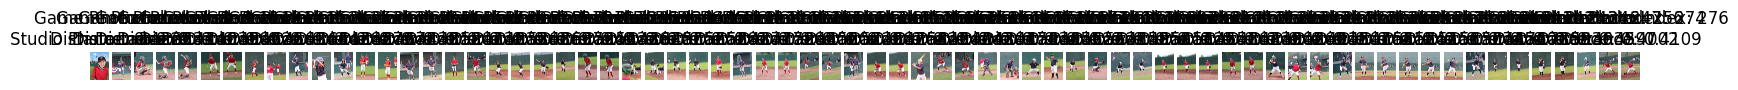

Matching game photos for studio photo index 1:
[(5, 0.4307531), (8, 0.40895987), (9, 0.40531194), (12, 0.6982527), (13, 0.6016966), (15, 0.41401482), (18, 0.42631215), (21, 0.4029919), (22, 0.4991531), (23, 0.57285666), (24, 0.5908948), (34, 0.52751106), (43, 0.6546513), (44, 0.6605075), (46, 0.40055424), (57, 0.4209203), (58, 0.4477055), (59, 0.4702897), (72, 0.7668941), (73, 0.6846646), (74, 0.6812054), (82, 0.49625418), (83, 0.4276095), (85, 0.40825036), (86, 0.6697636), (87, 0.64303595), (88, 0.6872312), (89, 0.44708246), (90, 0.43340808), (91, 0.41689765), (93, 0.5199945), (96, 0.48887423), (97, 0.48519325), (98, 0.42079934), (99, 0.45320833), (103, 0.45320833), (107, 0.46569848), (116, 0.49459276), (118, 0.58331764), (122, 0.428169), (130, 0.44070715), (133, 0.5203675), (135, 0.4039759), (137, 0.46014), (138, 0.47728434), (145, 0.4972134), (151, 0.43414274), (166, 0.45938438), (168, 0.45297307), (170, 0.50303626), (174, 0.48337412), (176, 0.4951253), (178, 0.46568155), (179, 0.45

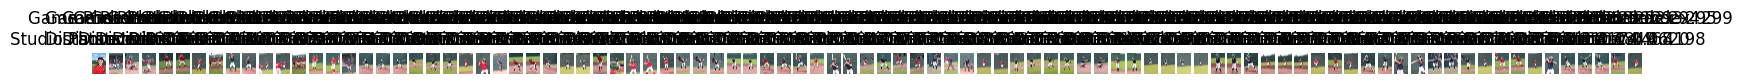

Matching game photos for studio photo index 2:
[(69, 0.4149229), (70, 0.47356737), (71, 0.5423683), (91, 0.44080734), (94, 0.56363904), (110, 0.4943729), (112, 0.4771493), (158, 0.6667817), (168, 0.45584145), (174, 0.42333338), (177, 0.5943643), (207, 0.6937529), (208, 0.75538445), (213, 0.47227472), (216, 0.49165055), (220, 0.4357984), (236, 0.722138), (237, 0.72684234), (238, 0.78235596), (239, 0.7523898), (240, 0.641789), (246, 0.5281178), (247, 0.5379908), (256, 0.79018956), (270, 0.5011839), (271, 0.5123475), (274, 0.5411067), (275, 0.51021177), (283, 0.41368765)]


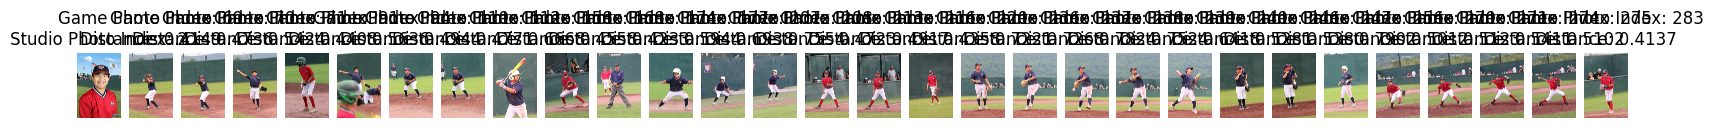

Matching game photos for studio photo index 3:
[(4, 0.47391936), (7, 0.4407254), (11, 0.46911663), (55, 0.5317053), (56, 0.6148797), (57, 0.57309437), (58, 0.47174054), (82, 0.40489462), (83, 0.4151852), (87, 0.53958905), (119, 0.50582325), (120, 0.40328297), (121, 0.4401549), (133, 0.4653405), (137, 0.4005813), (168, 0.42213297), (178, 0.5383686), (179, 0.42825454), (198, 0.40846157), (199, 0.42695352), (209, 0.48991174), (213, 0.40436837), (216, 0.40479216), (224, 0.46210906), (230, 0.43304616), (247, 0.4173767), (269, 0.44656903), (298, 0.500067), (299, 0.51089466), (300, 0.44491088)]


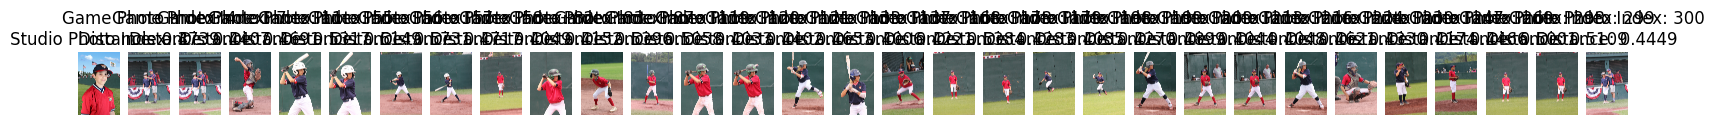

Matching game photos for studio photo index 4:
[(88, 0.42670667), (122, 0.40042686), (131, 0.51760745), (137, 0.4187088), (138, 0.42822874), (183, 0.4941517), (206, 0.43750125), (225, 0.43214864), (226, 0.4653008)]


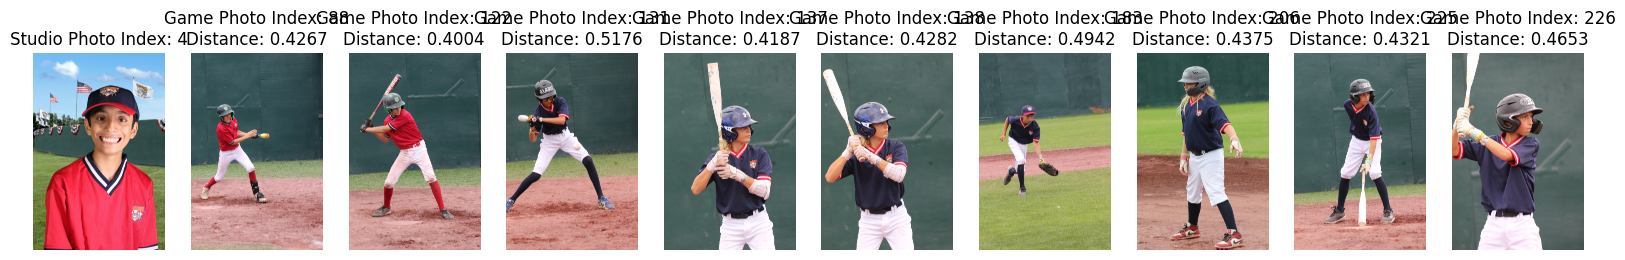

Matching game photos for studio photo index 5:
[(8, 0.45910612), (9, 0.54504335), (10, 0.47211254), (11, 0.4792716), (12, 0.45549074), (13, 0.43969154), (27, 0.50208735), (43, 0.47453332), (44, 0.47483435), (53, 0.4038025), (62, 0.40642434), (69, 0.5315945), (70, 0.5261912), (71, 0.4718969), (77, 0.40047655), (89, 0.6541748), (90, 0.5084119), (94, 0.5696988), (95, 0.45579207), (110, 0.53616065), (112, 0.5488329), (114, 0.6234837), (115, 0.5629166), (126, 0.4430475), (133, 0.5818218), (135, 0.64968467), (136, 0.5138618), (142, 0.4050321), (148, 0.43707234), (156, 0.46764478), (157, 0.5315545), (163, 0.66658336), (164, 0.52429056), (168, 0.41280854), (176, 0.5168003), (180, 0.47310537), (189, 0.45099315), (197, 0.57152164), (198, 0.59178615), (199, 0.60785186), (200, 0.46957543), (209, 0.6698419), (210, 0.48407272), (211, 0.50473034), (212, 0.47930145), (221, 0.5626161), (222, 0.5362882), (224, 0.7608287), (228, 0.5176718), (230, 0.5904558), (232, 0.5244559), (233, 0.5818875), (234, 0.40

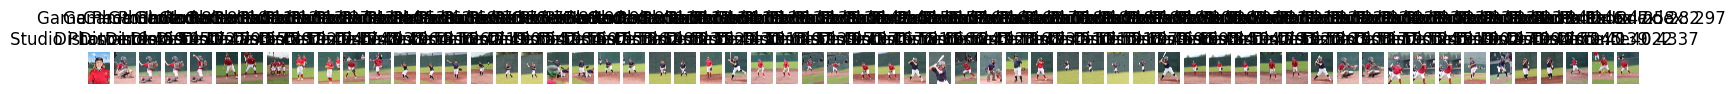

Matching game photos for studio photo index 6:
[(12, 0.5287454), (13, 0.48495233), (16, 0.567006), (21, 0.5530835), (22, 0.54560333), (23, 0.55519354), (24, 0.49295872), (32, 0.5177715), (37, 0.45529923), (43, 0.5027771), (44, 0.5054422), (57, 0.48227167), (72, 0.43746993), (75, 0.62933934), (77, 0.5257994), (79, 0.58435035), (86, 0.5245099), (87, 0.48892277), (89, 0.41322374), (93, 0.42504364), (107, 0.45807308), (116, 0.5585068), (118, 0.55866957), (119, 0.42639703), (120, 0.42094657), (121, 0.40830538), (135, 0.42276272), (178, 0.49576724), (179, 0.5314424), (183, 0.46932375), (189, 0.4350556), (190, 0.43717903), (191, 0.48937735), (193, 0.58839244), (194, 0.61818355), (205, 0.4017651), (206, 0.45407712), (210, 0.5048157), (211, 0.44238913), (212, 0.48549104), (221, 0.44328976), (232, 0.42848617), (233, 0.4201863), (235, 0.4736132), (241, 0.44843906), (244, 0.704402), (245, 0.6708727), (281, 0.51097935), (282, 0.53081167), (301, 0.4194231)]


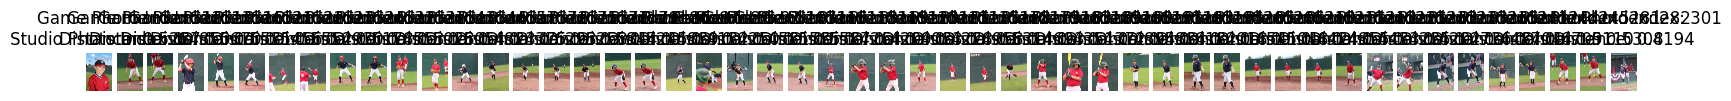

Matching game photos for studio photo index 7:
[(13, 0.4015273), (14, 0.4663949), (15, 0.5070919), (24, 0.60458463), (27, 0.48719215), (28, 0.44103593), (29, 0.480976), (30, 0.51401323), (39, 0.40440413), (43, 0.4032082), (44, 0.44034), (45, 0.40990746), (47, 0.40809005), (49, 0.48220086), (50, 0.44108337), (60, 0.5129405), (62, 0.44809663), (63, 0.5512762), (69, 0.84147334), (70, 0.8868449), (71, 0.8837576), (75, 0.47400686), (77, 0.45725042), (79, 0.4302722), (82, 0.4674147), (89, 0.46929944), (90, 0.4046265), (91, 0.5387083), (92, 0.52817005), (94, 0.88176984), (95, 0.67224675), (98, 0.40104154), (100, 0.42609197), (104, 0.42609197), (110, 0.87696844), (112, 0.88853025), (114, 0.41457334), (115, 0.40155125), (127, 0.41985494), (133, 0.45062757), (134, 0.50548124), (135, 0.5489403), (136, 0.5188662), (140, 0.4026137), (142, 0.57768595), (148, 0.64323974), (150, 0.40289313), (156, 0.61191905), (157, 0.69126236), (158, 0.6441034), (166, 0.607625), (167, 0.41144323), (168, 0.63350254), 

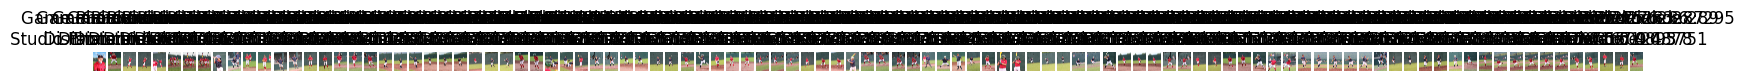

Matching game photos for studio photo index 8:
[(10, 0.40892234), (12, 0.52416784), (13, 0.40193328), (22, 0.419326), (23, 0.47210908), (24, 0.52492714), (27, 0.56842893), (29, 0.45690644), (31, 0.4464869), (34, 0.5164411), (43, 0.49964866), (44, 0.5801087), (70, 0.41158012), (75, 0.58331406), (77, 0.4659871), (79, 0.42608446), (82, 0.48208302), (85, 0.40360498), (87, 0.4124037), (88, 0.404045), (89, 0.5117895), (90, 0.45034972), (91, 0.47728443), (92, 0.4348997), (94, 0.45673153), (98, 0.4115976), (100, 0.47509956), (104, 0.47509956), (110, 0.43390143), (112, 0.4319748), (113, 0.45564678), (114, 0.49362025), (115, 0.4405197), (116, 0.40234762), (118, 0.49298486), (126, 0.4036298), (128, 0.4277098), (133, 0.5542009), (134, 0.44609636), (135, 0.42361057), (136, 0.4068464), (148, 0.4109313), (158, 0.43771118), (161, 0.4211917), (163, 0.42594624), (164, 0.40087), (166, 0.6443372), (168, 0.6005269), (172, 0.51925963), (174, 0.55492795), (186, 0.5566567), (187, 0.5518904), (188, 0.5686604),

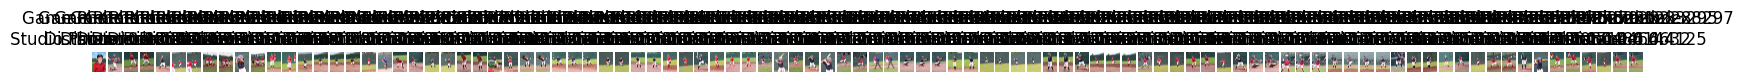

Matching game photos for studio photo index 9:
[(12, 0.5432316), (13, 0.5307064), (24, 0.48694372), (43, 0.54449975), (44, 0.5238501), (56, 0.4310419), (57, 0.46098796), (58, 0.4089964), (63, 0.4345434), (69, 0.40601522), (72, 0.4826608), (75, 0.4297366), (77, 0.41874316), (79, 0.4370504), (82, 0.50876033), (83, 0.4927572), (86, 0.53141063), (87, 0.51950526), (88, 0.5441774), (89, 0.48471344), (90, 0.41132125), (94, 0.43874925), (96, 0.46128035), (99, 0.5982677), (103, 0.5982677), (107, 0.6556101), (116, 0.4872205), (117, 0.44770464), (118, 0.5104816), (119, 0.57873213), (120, 0.46208012), (121, 0.431297), (133, 0.5284658), (135, 0.5110593), (136, 0.47015658), (137, 0.46713117), (138, 0.4794367), (151, 0.54338163), (157, 0.44397235), (163, 0.45721075), (164, 0.4522875), (168, 0.47520027), (170, 0.5441072), (178, 0.5964091), (179, 0.5966254), (183, 0.6003994), (193, 0.40726563), (194, 0.4256757), (197, 0.46412593), (198, 0.517261), (199, 0.47437274), (200, 0.4433921), (205, 0.50022894),

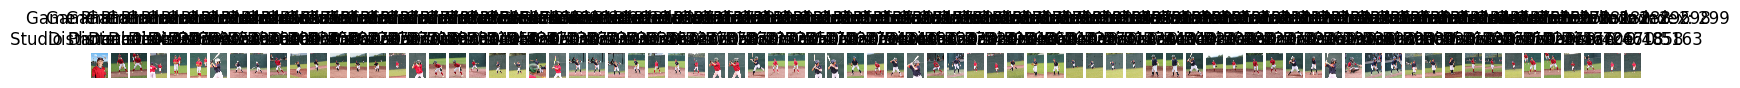

Matching game photos for studio photo index 10:
[(8, 0.42497015), (13, 0.46213132), (18, 0.42714646), (24, 0.40678436), (63, 0.41808856), (69, 0.4884536), (70, 0.520957), (71, 0.4344923), (82, 0.41665155), (87, 0.42150426), (88, 0.4036489), (94, 0.56263816), (96, 0.40582412), (107, 0.46512455), (110, 0.45168245), (112, 0.47833425), (119, 0.46971637), (127, 0.48372322), (133, 0.43609798), (134, 0.52668345), (135, 0.4396488), (136, 0.41498825), (140, 0.40665993), (157, 0.41140747), (168, 0.49904048), (178, 0.5510727), (179, 0.5357944), (180, 0.4350214), (183, 0.44332576), (186, 0.43907976), (187, 0.4615423), (188, 0.51122105), (199, 0.43630242), (204, 0.44525385), (205, 0.40588063), (206, 0.40582195), (209, 0.42342103), (213, 0.4747611), (216, 0.46275264), (221, 0.47992656), (222, 0.44498098), (224, 0.4921695), (228, 0.44375393), (230, 0.51132), (235, 0.4716863), (239, 0.44827408), (241, 0.49749678), (246, 0.47584784), (247, 0.4171555), (265, 0.40192544), (268, 0.45928454), (269, 0.49104

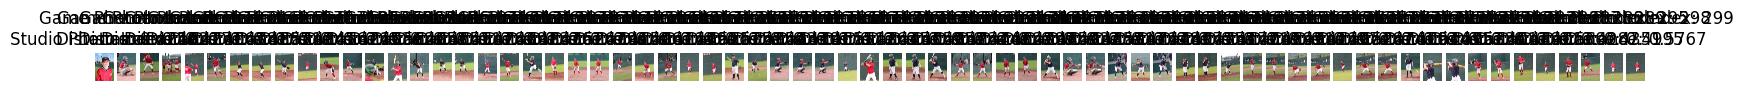

Matching game photos for studio photo index 11:
[(5, 0.4955564), (6, 0.6736638), (13, 0.42401755), (24, 0.5355521), (38, 0.6565446), (40, 0.53710103), (43, 0.44629177), (44, 0.4717105), (51, 0.43146396), (72, 0.5940667), (74, 0.42472735), (86, 0.50514036), (93, 0.4331928), (122, 0.43104082), (126, 0.43411398), (128, 0.4140103), (134, 0.5669144), (172, 0.4380508), (181, 0.47192377), (182, 0.42447102), (183, 0.5861416), (184, 0.44244188), (185, 0.49897456), (210, 0.47849655), (212, 0.5096339), (225, 0.43740845), (227, 0.41437298), (287, 0.41289616), (289, 0.46238586), (290, 0.5983156), (291, 0.55546373), (292, 0.47883454), (293, 0.67763436), (294, 0.6281554), (301, 0.738309)]


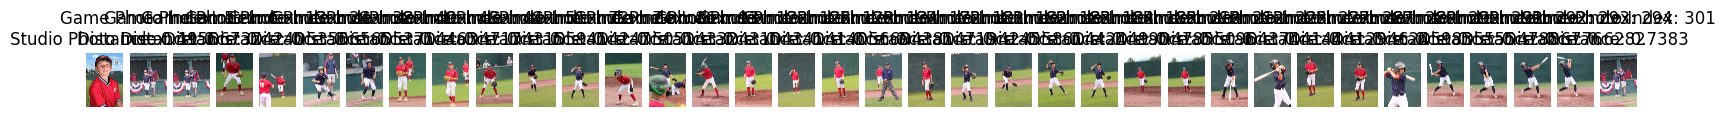

In [58]:
# Display results, but load and display the original images (using the file paths)
for studio_idx, matches in results.items():
    print(f'Matching game photos for studio photo index {studio_idx}:')
    print(matches)  # List of matched game photos (indices and distances)
    if matches:
        # Load and display the studio image using the file path
        studio_image = Image.open(studio_photos_paths[studio_idx])
        # Set up the plot for studio and matched game images
        plt.figure(figsize=(20, 6))
        plt.subplot(1, len(matches) + 1, 1)
        plt.imshow(studio_image)
        plt.title(f'Studio Photo Index: {studio_idx}')
        plt.axis('off')
        # Display each matched game image using the original file path
        for i, (game_idx, distance) in enumerate(matches):
            game_image = Image.open(match_photos_paths[game_idx])  # Load the match image by path
            plt.subplot(1, len(matches) + 1, i + 2)
            plt.imshow(game_image)
            plt.title(f'Game Photo Index: {game_idx}\nDistance: {distance:.4f}')
            plt.axis('off')
        # Show the plot with studio and match images
        plt.show()
    else:
        print("No matches found.")